In [205]:
'''
File name: preprocessing.ipynb
Authors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt
Date created: 04/11/2022
Date last modified: 18/11/2022
Python version: 3.8.8
'''

'\nFile name: preprocessing.ipynb\nAuthors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt\nDate created: 04/11/2022\nDate last modified: 18/11/2022\nPython version: 3.8.8\n'

# The evolution of the gender gap in the film industry
Our goal here is to analyze the evolution of sexism and women discrimination in the film industry with time. 
With the #MeToo movement in 2017 (started in 2007 but was not so well known.), we expect a positive evolution in the gender gap in the movie industry and elsewhere. Did the MeToo movement really impact the situation? We could compare the data before 2007, between 2007 and 2016, and after 2017 to see if the different stages of the movement made things change.

In order to evaluate the gender gap in the film industry, we will have a look at 3 different axis.
First, we'll check the financial aspect, trying to correlate the numbers to discrimination (while being careful to confounders). We'll have a look at the box office revenues and we will try to find the salaries of actors and actresses to assess if we can find evidence of discrimination in those numbers.
Secondly, we will analyze the evolution of the types of roles attributed to women, to see if there is an improvement in this sense to diminish the gender gap. To do so, we will look at textual data with NLP libraires (i.e. we will treat the summaries) through topic detection, sentiment analysis, feminine pronouns occurences, etc. to extract information on the type of roles and the types of representation of women in movies. The importance of the role will also be evaluated. Tropes and stereotypes will be analyzed too, from the adequate dataset, and put into relation with the summaries.
### THIRD AXIS ?!!!!

## Table of contents

0. [General Information](#GI)\
        A. [Folder structure](#Folder)\
        B. [Data](#Data)\
        C. [Imports](#Imports)\
        D. [Paths](#Paths)
</br> 
1. [Step 1: Data scraping, pre-processing and dataset construction](#Step-1)\
        A. 
</br> 

---
## General Information <a id="GI"> </a> 

### Folder structure <a id="Folder"> </a>

***Files and directories to make this notebook run successfully:***

- **data/**
    - *character.metadata.tsv*
    - *movie.metadata.tsv*
    - *name.clusters.txt*
    - *plot_summaries.txt*
    - *tvtropes.clusters.txt*
- *preprocessing.ipynb*

Directories are in **bold** and files are in *italic*.


`movie.metadata.tsv.gz` [3.4 M]

Metadata for 81,741 movies, extracted from the November 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


`name.clusters.txt`

970 unique character names used in at least two different movies, along with 2,666 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


`plot_summaries.txt.gz` [29 M] 

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.


`tvtropes.clusters.txt`

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


`corenlp_plot_summaries.tar.gz` [628 M, separate download]

The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).


### Imports <a id="Imports"> </a>

***Libraries used for milestone 2:***
- python=3.8.12
- pandas
- datetime
- numpy
- matplotlib

In [206]:
#Imports used in this notebook
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import helper
import json


### Paths <a id="Paths"> </a>

Required to adapt those path to local file organization

In [207]:
### PATHs for dataset:
PATH_DATA = 'data/'
PATH_MOVIE_METADATA = PATH_DATA+'movie.metadata.tsv'
PATH_PLOT_SUMMARY = PATH_DATA+'plot_summaries.txt'
PATH_CHARACTER_METADATA = PATH_DATA+'character.metadata.tsv'
PATH_NAME_CLUSTERS=PATH_DATA+'name.clusters.txt'
PATH_TV_TROPES_CLUSTERS=PATH_DATA+'tvtropes.clusters.txt'

---
## **Step 1: Data scraping, pre-processing and dataset construction** <a id="Step-1"> </a>

## Pas compris ce que tu voulais dire ici
First we will properly name each column of in order to manipulate in an easier way.

In [208]:
def dict_to_cols(row): 
    '''
    Allows to transform the dictionnary into a dataframe with multiple columns.
    :param row : row to transform
    :return : 
    '''
    d = js.loads(row[1])
    return row[0], *list(d.values())

def dict_to_lst(stri):
    '''
    Allows to transform a dictionnary into a list of features.
    :param stri : 
    :return : list of features
    '''
    dict = ast.literal_eval(stri)
    lst  = list(dict.values())
    return lst

We have extracted the data and can see that there is some preprocessing to be done.

`movie.metadata.tsv.gz`
Firstly, the movie release dates are not standardized: some are in a year-month-day format and some only have the release year. Secondly, for some of the columns (Movie languages, Movie countries, and Movie genres) the way we the data is presented might not be the best (dictionary with ID and actual "value).
We also need to look for any column containing NaN values and see what we want to do with these missing values. Depending on what data we need for each of our research axis, we might deal differently with NaNs.

In [209]:
print("Reading in movie data")

#Read in movie metadata, plot summaries, and character metadata.
movie_headers = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name','Movie release date','Movie box office revenue',
                 'Movie runtime','Movie languages','Movie countries','Movie genres']
plot_headers = ['Wikipedia movie ID','Plot Summary']
character_headers = ['Wikipedia movie ID', 'Freebase movie ID','Movie release date','Character name','Actor date of birth',
                     'Actor gender','Actor height','Actor ethnicity','Actor name','Actor age at movie release',
                     'Freebase character/actor map ID','Freebase character ID','Freebase actor ID']
name_clusters_headers=['Character name', 'id']
name_clusters_headers=['Character name', 'id']
tv_tropes_cluster_headers=['Trope','Character name','movie','id','actor']


movie_metadata = pd.read_csv(PATH_MOVIE_METADATA,sep='\t',header=None,names=movie_headers,index_col=0)
plot_summaries = pd.read_csv(PATH_PLOT_SUMMARY,sep='\t',index_col=0,names=plot_headers)
character_metadata = pd.read_csv(PATH_CHARACTER_METADATA,sep='\t',header=None,names=character_headers,index_col='Wikipedia movie ID')
name_clusters=pd.read_csv(PATH_NAME_CLUSTERS,sep='\t',header=None,names=name_clusters_headers,index_col='id')
tv_tropes_clusters = pd.read_csv(PATH_TV_TROPES_CLUSTERS,sep='\t',header=None).apply(dict_to_cols, axis=1, result_type='expand')

tv_tropes_clusters.columns = tv_tropes_cluster_headers
tv_tropes_clusters.set_index('id')
movie_metadata['Movie languages']=movie_metadata['Movie languages'].apply(lambda x: dict_to_lst(x))
movie_metadata['Movie countries']=movie_metadata['Movie countries'].apply(lambda x: dict_to_lst(x))
movie_metadata['Movie genres']=movie_metadata['Movie genres'].apply(lambda x: dict_to_lst(x))

display(movie_metadata.head())
display(plot_summaries.head())
display(character_metadata.head())
display(name_clusters.head())
display(tv_tropes_clusters.head())

Reading in movie data


,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


,Plot Summary
Wikipedia movie ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
Wikipedia movie ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


,Character name
id,
/m/0k3w9c,Stuart Little
/m/0k3wcx,Stuart Little
/m/0k3wbn,Stuart Little
/m/0jyg35,John Doe
/m/0k2_zn,John Doe


,Trope,Character name,movie,id,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


First of all, we make an inspection of the dataframes, to see wether there exists some duplicates, NaN values etc... 

In [210]:
movie_metadata.index.is_unique

True

In [211]:
movie_metadata.isna().any()

Freebase movie ID           False
Movie name                  False
Movie release date           True
Movie box office revenue     True
Movie runtime                True
Movie languages             False
Movie countries             False
Movie genres                False
dtype: bool

Sum of NaN in each feature : 


Freebase movie ID               0
Movie name                      0
Movie release date           6902
Movie box office revenue    73340
Movie runtime               20450
Movie languages                 0
Movie countries                 0
Movie genres                    0
dtype: int64

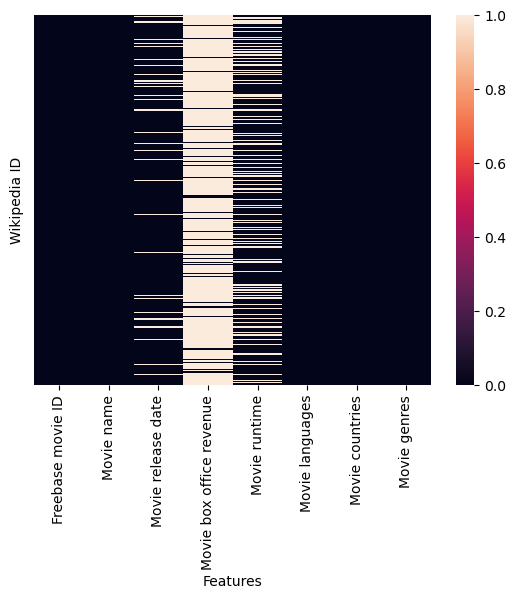

In [212]:
ax=sns.heatmap(movie_metadata.isna(), yticklabels=False)
ax.set(xlabel="Features", ylabel="Wikipedia ID")
print('Sum of NaN in each feature : ')
movie_metadata.isna().sum(axis = 0)

In [213]:
n_movie=len(movie_metadata)
print('Percentage of missing entries in the movie.metadata dataset:\n', 100*movie_metadata[['Movie release date', 'Movie box office revenue', 'Movie runtime']].isna().sum() / n_movie)

Percentage of missing entries in the movie.metadata dataset:
 Movie release date           8.443743
Movie box office revenue    89.722416
Movie runtime               25.018045
dtype: float64


We are missing a lot of the data on the movie box office revenue. Maybe we should try and find those missing informations in another dataset as this could be helpful in our analysis. For the release dates and runtime we could discard the rows with missing values but it could be interesting to check if the rows discarded contain on average more or less lead women characters  or women directors so that we don't overlook any data.

`plot_summaries.txt.gz`

In [214]:
plot_summaries.head()

,Plot Summary
Wikipedia movie ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


In [215]:
plot_summaries.index.is_unique

True

In [216]:
print('Sum of NaN in each feature : ')
plot_summaries.isna().sum(axis = 0)

Sum of NaN in each feature : 


Plot Summary    0
dtype: int64

The summary dataset seems to be relatively clean. ¥

`character.metadata.tsv.gz`

In [217]:
character_metadata.head()

,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
Wikipedia movie ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [218]:
character_metadata.isna().any()

Freebase movie ID                  False
Movie release date                  True
Character name                      True
Actor date of birth                 True
Actor gender                        True
Actor height                        True
Actor ethnicity                     True
Actor name                          True
Actor age at movie release          True
Freebase character/actor map ID    False
Freebase character ID               True
Freebase actor ID                   True
dtype: bool

Sum of NaN in each feature : 


Freebase movie ID                       0
Movie release date                   9995
Character name                     257875
Actor date of birth                106145
Actor gender                        45609
Actor height                       295845
Actor ethnicity                    344611
Actor name                           1228
Actor age at movie release         158113
Freebase character/actor map ID         0
Freebase character ID              257865
Freebase actor ID                     815
dtype: int64

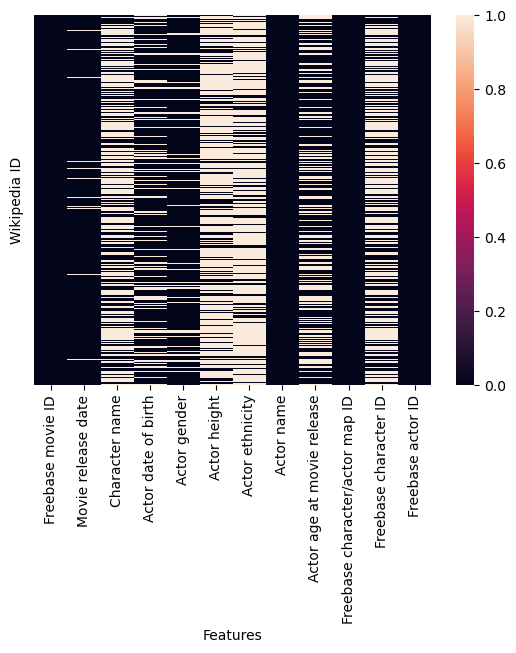

In [219]:
ax=sns.heatmap(character_metadata.isna(), yticklabels=False)
ax.set(xlabel="Features", ylabel="Wikipedia ID")
print('Sum of NaN in each feature : ')
character_metadata.isna().sum(axis = 0)

In [220]:
n_char=len(character_metadata)
print('Percentage of missing entries in the character.metadata dataset:\n', 100*character_metadata[['Freebase movie ID', 'Movie release date', 'Character name',
                                                                                   'Actor date of birth', 'Actor gender', 'Actor height', 'Actor ethnicity',
                                                                                   'Actor name', 'Actor age at movie release', 'Freebase character ID',
                                                                                   'Freebase actor ID']].isna().sum() / n_char)

Percentage of missing entries in the character.metadata dataset:
 Freebase movie ID              0.000000
Movie release date             2.217814
Character name                57.220488
Actor date of birth           23.552763
Actor gender                  10.120288
Actor height                  65.645740
Actor ethnicity               76.466542
Actor name                     0.272484
Actor age at movie release    35.084064
Freebase character ID         57.218269
Freebase actor ID              0.180842
dtype: float64


We are missing a lot of data on actor's and actresses' ethnicities and their heights. This should not affect our analysis a we did not plan on using these features initially. For the other features we need to figure out if they are relevant to our analysis, and if so, need to decide wheter we want to discard the rows containing NaNs or try and find the information elsewhere.

In [221]:
n_movie = len(movie_metadata)
n_summaries = len(plot_summaries)
n_char = len(character_metadata)
n_name_clusters = len(name_clusters)
n_tropes_clusters = len(tv_tropes_clusters)

print('Number of rows in the movie.metadata dataset : %d' %n_movie)
print('Number of rows in the plot_summaries dataset : %d' %n_summaries)
print('Number of rows in the character.metadata dataset : %d' %n_char)
print('Number of rows in the name.clusters dataset : %d' %n_name_clusters)
print('Number of rows in the tvtropes.clusters dataset : %d' %n_tropes_clusters)

Number of rows in the movie.metadata dataset : 81741
Number of rows in the plot_summaries dataset : 42303
Number of rows in the character.metadata dataset : 450669
Number of rows in the name.clusters dataset : 2666
Number of rows in the tvtropes.clusters dataset : 501


We check for duplicated rows in the `plot_summaries` dataset and the `character.metadata` dataset as we don't want duplicates. We do not need to check for specific features duplicated as it could be possible and would not be a problem

In [222]:
print("Duplicated rows in the plot_summaries dataset : {}".format(plot_summaries.duplicated().sum()))
print("Duplicated rows in character.metadata dataset : {}".format(character_metadata.duplicated().sum()))

Duplicated rows in the plot_summaries dataset : 8
Duplicated rows in character.metadata dataset : 0


For the `movie_ metadata` dataset, we need to check duplicated depending on rows. As we don't want for example the same movie with different Movie release dates, or different Freebase movie IDs.

In [223]:
print("Duplicated rows in the movie_metadata dataset :")
#Looking for duplicates in our datasets
for f in movie_metadata.columns:
    dupl = movie_metadata[f].duplicated().sum()
    print("{} has {} duplicated rows".format(f, dupl))

Duplicated rows in the movie_metadata dataset :
Freebase movie ID has 0 duplicated rows
Movie name has 6263 duplicated rows
Movie release date has 61351 duplicated rows
Movie box office revenue has 74378 duplicated rows
Movie runtime has 81143 duplicated rows
Movie languages has 79924 duplicated rows
Movie countries has 79617 duplicated rows
Movie genres has 57924 duplicated rows


We can see that there are 6263 movies with the same title. This could be concerning. However, as no movie has the same Wikipedia movie ID or Freebase movie ID, we could assume that these title duplications are only movies with the same title and not the same movie just duplicated.

In [224]:
print("What is needed to be processed:")
print("Rows with actor age at movie release under or equal to 0: %d" %len(character_metadata[character_metadata['Actor age at movie release']<=0]))
print("Rows with actor height under or equal to 0: %d" %len(character_metadata[character_metadata['Actor height']<=0]))
print("Rows with movie runtime under or equal to 0: %d" %len(movie_metadata[movie_metadata['Movie runtime']<=0]))

What is needed to be processed:
Rows with actor age at movie release under or equal to 0: 433
Rows with actor height under or equal to 0: 0
Rows with movie runtime under or equal to 0: 1


In [225]:
movie_metadata[movie_metadata["Movie name"]=="Hunting Season"]

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]"


We can see that the release date of this movie is wrong. 1010-12-02 should be 2010-12-02. We correct this.

In [226]:
movie_metadata.loc[movie_metadata['Movie release date'] == '1010-12-02','Movie release date'] = '2010-12-02'

In [227]:
movie_metadata[movie_metadata["Movie name"]=="Hunting Season"]

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
29666067,/m/0fphzrf,Hunting Season,2010-12-02,12160978.0,140.0,"[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]"


We see that some of the Movie release dates only contain the year and not the full year-month-day date so we correct this to have a standardized way of having our Movie release dates.

In [228]:
#01-01-Year for movies only including a year for the dates
movie_metadata["Movie release date"] = pd.to_datetime(movie_metadata["Movie release date"],errors='coerce') 
movie_metadata.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


In [229]:
#marche pas, on fait quoi avec ça ?
'''
sns.histplot(data=movie_metadata)
plt.title('Movie release year')
'''

"\nsns.histplot(data=movie_metadata)\nplt.title('Movie release year')\n"

# Step 2: first analysis of women representation in the film industry - number of actresses vs. actors in the character metadata dataset

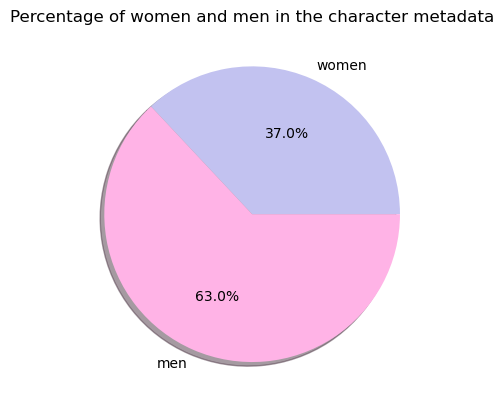

In [230]:
fem_act = character_metadata[character_metadata['Actor gender'] == 'F']
masc_act = character_metadata[character_metadata['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata')
plt.show()

In [231]:
#replace NaN values with 0
character_metadata_clean = character_metadata.fillna(0)
movie_metadata_clean = movie_metadata.fillna(0)

In [232]:

#new dataframe with movies after 2007 after converting the release date to datetime some dates are only year so we need to add the month and day

movie_metadata_clean['Movie release date'] = pd.to_datetime(movie_metadata_clean['Movie release date'],errors='coerce')
movie_metadata_clean = movie_metadata_clean[movie_metadata_clean['Movie release date'] > datetime(2007,1,1)]
movie_metadata_clean.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
21926710,/m/05p45cv,White on Rice,2009-01-01,0.0,82.0,[],[United States of America],"[Romantic comedy, Romance Film, Comedy, Indie]"
20604092,/m/0523t_1,Anbu Thozhi,2007-08-17,0.0,0.0,[Tamil Language],[India],[Romance Film]
29772142,/m/0fq260_,Karayilekku Oru Kadal Dooram,2010-12-31,0.0,110.0,[Malayalam Language],[India],[Drama]
26623942,/m/0bh9fbk,Kausthubham,2010-03-19,0.0,0.0,[Malayalam Language],[India],[Drama]
32445576,/m/0gyv1h1,Vinayaka Geleyara Balaga,2011-07-15,0.0,0.0,[],[],[]


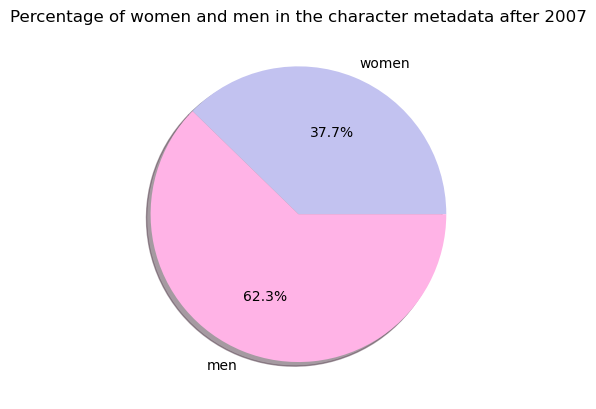

In [233]:
#only keep characters with 'wikipedia movie ID' in movie_metadata_clean after 2007
character_metadata_clean = character_metadata_clean[character_metadata_clean.index.isin(movie_metadata_clean.index)]
#number of female actors compared to male actors for movies after 2007 plotted in a pie chart
fem_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'F']
masc_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata after 2007')
plt.show()

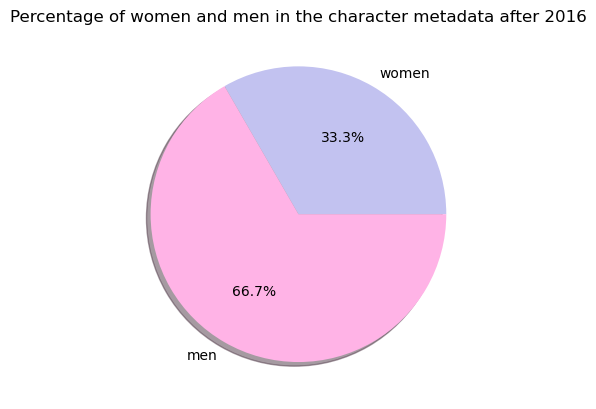

In [234]:
#new dataframe with movies after 2016 
movie_metadata_clean = movie_metadata_clean[movie_metadata_clean['Movie release date'] > datetime(2016,1,1)]
#only keep characters with 'wikipedia movie ID' in movie_metadata_clean after 2016
character_metadata_clean = character_metadata_clean[character_metadata_clean.index.isin(movie_metadata_clean.index)]
#number of female actors compared to male actors for movies after 2016 plotted in a pie chart
fem_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'F']
masc_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata after 2016')
plt.show()

In [235]:
"""
Don't use character_metadata_clean as it has been defined lastly as with the movies released after 2016 only (there are only 2)
"""

#analysing plot summaries to find main character is the one whose name is mentioned the most
#we will use the first 1000 characters of the plot summary to find the main character

#function to find the main character in a plot summary
def find_main_character(plot_summary):
    #create a list of all the characters in the plot summary
    characters = character_metadata_clean[character_metadata_clean.index == plot_summary.name]['Character name'].to_list()
    #create a list of the number of times each character is mentioned in the plot summary
    character_count = [plot_summary['Plot Summary'][:2000].count(character) for character in characters]
    #return the character with the highest number of mentions
    return characters[np.argmax(character_count)]   

#apply the function to the plot summaries
#plot_summaries['Main character'] = plot_summaries.apply(find_main_character(plot_summaries),axis=1)
#plot_summaries.head()

Our analysis could be done here: there is discrimination in the film industry as women are under-representated. They only stand for 1/3 of characters in the studied movies in our datasets. But it is not as simple as that... how does this gender gap evolves in time, and particularly, how is it linked to the type of roles women are attributed to?

# Step 3: Discrimination through salaries, box office revenues, etc.

In [236]:
print("Movies with biggest box office revenues:")
movie_metadata.sort_values('Movie box office revenue', ascending = False).head()

Movies with biggest box office revenues:


,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"[English Language, Spanish Language]","[United States of America, United Kingdom]","[Thriller, Science Fiction, Adventure, Compute..."
52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"[Italian Language, English Language, French La...",[United States of America],"[Tragedy, Costume drama, Historical fiction, A..."
22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"[Russian Language, English Language]",[United States of America],"[Science Fiction, Action]"
31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,[English Language],"[United States of America, United Kingdom]","[Drama, Mystery, Fantasy, Adventure]"
25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,[English Language],[United States of America],"[Alien Film, Science Fiction, Action, Adventure]"


In [237]:
#Find movies without box office revenue and filter them out
no_rev = movie_metadata.loc[movie_metadata['Movie box office revenue'].isnull()].index
movie_metadata_filt = movie_metadata.drop(no_rev)

In [238]:
movie_metadata.shape[0]

81741

In [239]:
movie_metadata_filt.shape[0]

8401

We only have 8401 movies where we have their box office revenue.

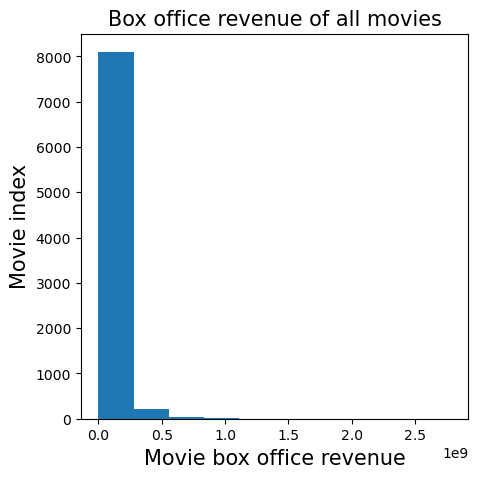

In [240]:
#Histogram of box office revenue of movies

plt.figure(figsize=(5,5), dpi = 100)
plt.xlabel('Movie box office revenue', fontsize = 15)
plt.ylabel('Movie index', fontsize=15)
plt.title('Box office revenue of all movies', fontsize=15)

plt.hist(movie_metadata_filt['Movie box office revenue'])

plt.show()

In [241]:
print("Movies with biggest box office revenues:")
movie_metadata.sort_values('Movie box office revenue', ascending = False).head()

Movies with biggest box office revenues:


,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"[English Language, Spanish Language]","[United States of America, United Kingdom]","[Thriller, Science Fiction, Adventure, Compute..."
52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"[Italian Language, English Language, French La...",[United States of America],"[Tragedy, Costume drama, Historical fiction, A..."
22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"[Russian Language, English Language]",[United States of America],"[Science Fiction, Action]"
31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,[English Language],"[United States of America, United Kingdom]","[Drama, Mystery, Fantasy, Adventure]"
25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,[English Language],[United States of America],"[Alien Film, Science Fiction, Action, Adventure]"


In [242]:
#No real use just to see
'''
plt.figure(figsize=(5,5), dpi = 100)
plt.xlabel('Movie release date', fontsize = 15)
plt.ylabel('Box office revenue', fontsize=15)
plt.title('Box office revenue of all movies', fontsize=15)

plt.plot(movie_metadata_filt["Movie release date"],movie_metadata_filt['Movie box office revenue'])

plt.show()
'''

'\nplt.figure(figsize=(5,5), dpi = 100)\nplt.xlabel(\'Movie release date\', fontsize = 15)\nplt.ylabel(\'Box office revenue\', fontsize=15)\nplt.title(\'Box office revenue of all movies\', fontsize=15)\n\nplt.plot(movie_metadata_filt["Movie release date"],movie_metadata_filt[\'Movie box office revenue\'])\n\nplt.show()\n'

In [243]:
character_dropna = character_metadata.dropna()
character_dropna

,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
Wikipedia movie ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
2314463,/m/0734w5,2006,Taper Guy,1971-05-26,M,1.870,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
612710,/m/02wjqm,1999-10-01,Sandii,1975-09-20,F,1.680,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq
...,...,...,...,...,...,...,...,...,...,...,...,...
22330502,/m/05sync6,1931-01-31,Yvonne Valbret,1905-09-18,F,1.702,/m/06mvq,Greta Garbo,25.0,/m/05tg4vb,/m/0h2ppfw,/m/0h14h
24997872,/m/09g6klx,2010-05-07,Raja,1951-09-07,M,1.780,/m/04mvp8,Mammootty,58.0,/m/0gvytkx,/m/0h27wx_,/m/02hkv5
24997872,/m/09g6klx,2010-05-07,Surya,1982-10-16,M,1.810,/m/0dryh9k,Prithviraj Sukumaran,27.0,/m/0gw0rm2,/m/0gz549m,/m/0cqcgj


In [244]:
'''
character_dropna['Actor gender'] = pd.get_dummies(character_dropna['Actor gender'])
character_dropna.head()
'''

"\ncharacter_dropna['Actor gender'] = pd.get_dummies(character_dropna['Actor gender'])\ncharacter_dropna.head()\n"

## Detecting Main characters etc.

In [245]:
plot_summaries.head()
character_metadata.head()
character_metadata=character_metadata.drop_duplicates()
print('there are normally', len(character_metadata),'characters')

there are normally 450669 characters


In [246]:
character_dropna_name = character_metadata.dropna(subset=['Character name'])
print('Percentage of missing entries in the name of the characters dataset:\n', 100*character_metadata[['Character name']].isna().sum() / n_char)

Percentage of missing entries in the name of the characters dataset:
 Character name    57.220488
dtype: float64


In [259]:
characters_plot=pd.merge(character_dropna_name,plot_summaries, left_index=True, right_index=True, how="inner")
characters_plot['Movie release date'] = pd.to_datetime(characters_plot['Movie release date'],errors='coerce')
characters_plot['Actor date of birth'] = pd.to_datetime(characters_plot['Actor date of birth'],errors='coerce') #might need to automate the process here
print('we will consider', len(character_dropna_name), 'characters and', len(characters_plot.index.drop_duplicates()),'movies')
characters_plot.head()

we will consider 192794 characters and 23068 movies


,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Plot Summary
Wikipedia movie ID,,,,,,,,,,,,,
3217,/m/014hr,1992-10-09,S-Mart Clerk,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/0hgcnkm,/m/0hgcnkq,/m/07qn0,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Fake shemp,1956-01-01,M,NaN,NaN,Ivan Raimi,36.0,/m/04hzm56,/m/089hc6,/m/0gmjf8,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Ash Williams,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtqtd,/m/06_krl,/m/01h8f,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Evil Ash,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtgxg0,/m/0jtgxg3,/m/01h8f,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Cowardly Warrior,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/04hzm5x,/m/0hgcnjh,/m/07qn0,"After being pulled through a time portal, Ash ..."


### Attention ici ça génère une erreur, qu'est-ce qu'on cherche à faire ?

In [265]:
characters_plot['Plot Summary']=characters_plot['Plot Summary'].replace("\","")
characters_plot.head()

SyntaxError: EOL while scanning string literal (3615930867.py, line 1)

In [266]:
characters_plot['Plot Summary'].iloc[0]

'After being pulled through a time portal, Ash Williams lands in 1300 AD, where he is almost immediately captured by Lord Arthur\'s men, who suspect him to be an agent for Duke Henry, with whom Arthur is at war. He is enslaved along with the captured Henry, his gun and chainsaw confiscated, and is taken to a castle. Ash is thrown in a pit where he fights off a Deadite and regains his weapons from Arthur\'s Wise Man. After demanding Henry and his men be set free  and killing a deadite in full view of everyone, Ash is celebrated as a hero. He also grows attracted to Sheila, the sister of one of Arthur\'s fallen knights. According to the Wise Man, the only way Ash can return to his time is to retrieve the Necronomicon Ex-Mortis. After bidding goodbye to Sheila, Ash starts his search for the Necronomicon. As he enters a haunted forest, an unseen force pursues Ash through the woods. Fleeing, he ducks into a windmill where he crashes into a mirror. The small reflections of Ash climb out from

In [268]:
def countOccurrences(str, word):
 
    wordslist = list(str.split())
    return wordslist.count(word)

## STEP 4 : Discrimination through types of roles attribution and its evolution in time

## Step 4.1: Summaries treatment

In [269]:
# feminine pronouns occurence in summaries

In [270]:
def indicator_variable(dic,x,s):
    '''
    Returns indicator variable which equals to 1 if the corresponding headline uses 
    the corresponding type of pronoun and 0 otherwise.
    :param dic: dictionary
    :param x: string
    :param s: string
    :return: indicator variable
    '''
    return int(bool(set(dic[s]) & set(x.lower().split(" "))))

In [271]:
feature_wordsets = dict([
    # https://en.wikipedia.org/wiki/English_personal_pronouns
    ('fem_pronoun', ['she','her','hers','herself', 
                               "she'll", "she's", 'shes']),
    ('masc_pronoun', ['he','him','his','himself',
                               "he'd", "he's", 'hes'])
])

plot_summaries["fem_pronoun"] = plot_summaries["Plot Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'fem_pronoun'))
plot_summaries["masc_pronoun"] = plot_summaries["Plot Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'masc_pronoun'))


In [272]:
plot_summaries

,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...",0,0
31186339,The nation of Panem consists of a wealthy Capi...,1,1
20663735,Poovalli Induchoodan is sentenced for six yea...,1,1
2231378,"The Lemon Drop Kid , a New York City swindler,...",1,1
595909,Seventh-day Adventist Church pastor Michael Ch...,1,1
...,...,...,...
34808485,"The story is about Reema , a young Muslim scho...",1,0
1096473,"In 1928 Hollywood, director Leo Andreyev look...",1,1
35102018,American Luthier focuses on Randy Parsons’ tra...,0,1


In [273]:
length_summaries = len(plot_summaries)

In [274]:
print('The number of summaries with feminine pronouns occurence:', sum(plot_summaries["fem_pronoun"]))
print('The percentage of summaries with feminine pronouns occurence:', 100*(sum(plot_summaries["fem_pronoun"]))/ length_summaries, "%")

The number of summaries with feminine pronouns occurence: 25181
The percentage of summaries with feminine pronouns occurence: 59.5253291728719 %


In [275]:
print('The number of summaries with masculine pronouns occurence:', sum(plot_summaries["masc_pronoun"]))
print('The percentage of summaries with masculine pronouns occurence:', 100*(sum(plot_summaries["masc_pronoun"]))/ length_summaries, "%")

The number of summaries with masculine pronouns occurence: 35197
The percentage of summaries with masculine pronouns occurence: 83.2021369642815 %


We observe that there is more than 23% difference between the occurence of feminine and masculine pronouns in the given summaries.

We can check if the pronouns occurence changes through time.

In [276]:
# add a release date column to the plot_summaries dataset

summaries_with_date = movie_metadata_filt.join(plot_summaries) #there were more summaries than given movies
summaries_with_date = summaries_with_date.dropna()
summaries_with_date["Movie release date"] = pd.to_datetime(summaries_with_date["Movie release date"],errors='coerce')
summaries_with_date = summaries_with_date.sort_values(by="Movie release date")
summaries_with_date.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,,,,,,,,,
3333,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac...",The film follows two juxtaposed families: the...,1.0,1.0
4499436,/m/0c5ppr,Way Down East,1920-01-01,4500000.0,147.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Black-and-white, Action/A...","The rich, typified by the handsome man-about-t...",1.0,1.0
1346905,/m/04vl27,The Kid,1921-01-01,2500000.0,60.0,"[Silent film, English Language]",[United States of America],"[Silent film, Drama, Indie, Black-and-white, C...",An unwed woman leaves a charity hospital carr...,1.0,1.0
21135479,/m/05b_29y,Little Lord Fauntleroy,1921-01-01,900000.0,112.0,"[Silent film, English Language]",[United States of America],"[Silent film, Drama, Comedy, Black-and-white, ...",Cedric Errol is a poor American boy who finds ...,0.0,1.0
2137591,/m/06pkq3,The Four Horsemen of the Apocalypse,1921-03-06,4500000.0,134.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Black-and-white, Drama, W...",The 1921 film is a fictional story inspired b...,1.0,1.0


In [277]:
#split dataset into three parts: before 2007, between 2007 and 2016, and after 2016

summaries_before2007 = summaries_with_date[summaries_with_date["Movie release date"] < "2007-01-01"]
summaries_2007 = summaries_with_date[(summaries_with_date["Movie release date"] >= "2007-01-01") & (summaries_with_date["Movie release date"] < "2016-01-01") ]
summaries_2016 = summaries_with_date[summaries_with_date["Movie release date"] >= "2016-01-01"]
display(summaries_before2007.head())
display(summaries_2007.head())
display(summaries_2016.head())

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,,,,,,,,,
3333,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac...",The film follows two juxtaposed families: the...,1.0,1.0
4499436,/m/0c5ppr,Way Down East,1920-01-01,4500000.0,147.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Black-and-white, Action/A...","The rich, typified by the handsome man-about-t...",1.0,1.0
1346905,/m/04vl27,The Kid,1921-01-01,2500000.0,60.0,"[Silent film, English Language]",[United States of America],"[Silent film, Drama, Indie, Black-and-white, C...",An unwed woman leaves a charity hospital carr...,1.0,1.0
21135479,/m/05b_29y,Little Lord Fauntleroy,1921-01-01,900000.0,112.0,"[Silent film, English Language]",[United States of America],"[Silent film, Drama, Comedy, Black-and-white, ...",Cedric Errol is a poor American boy who finds ...,0.0,1.0
2137591,/m/06pkq3,The Four Horsemen of the Apocalypse,1921-03-06,4500000.0,134.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Black-and-white, Drama, W...",The 1921 film is a fictional story inspired b...,1.0,1.0


,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,,,,,,,,,
13771001,/m/03chsvd,Earth,2007-01-01,108942691.0,90.0,"[Italian Language, Spanish Language, French La...","[United States of America, United Kingdom, Ger...","[Indie, Documentary]","Over the course of a calendar year, Earth take...",1.0,1.0
17240314,/m/043rbpp,Roman de Gare,2007-01-01,4826734.0,103.0,[French Language],[France],"[Thriller, Drama, Psychological thriller, Worl...","As the movie opens, a woman writer with a rece...",1.0,1.0
19380534,/m/04n3swj,Brief Interviews with Hideous Men,2007-01-01,27935.0,80.0,[English Language],[United States of America],"[Romantic comedy, Indie, Drama, Comedy, Film a...",Sara Quinn is interviewing men as part of her...,1.0,0.0
16660805,/m/03ykfv8,Inside,2007-01-01,786180.0,85.0,[French Language],[France],"[Horror, Psychological thriller, Slasher]",The film opens with a shot of a baby in utero...,1.0,1.0
8448026,/m/0273rqs,Eagle vs Shark,2007-01-01,1298037.0,93.0,[English Language],[New Zealand],"[Romantic comedy, Indie, World cinema, Comdedy...","Lily , a shy, wistful girl, is a songwriter wh...",1.0,1.0


,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,,,,,,,,,


In [278]:
print('The number of summaries before 2007 with feminine pronouns occurence:', sum(summaries_before2007["fem_pronoun"]))
print('The percentage of summaries before 2007 with feminine pronouns occurence:', 100*(sum(summaries_before2007["fem_pronoun"]))/ len(summaries_before2007), "%")

The number of summaries before 2007 with feminine pronouns occurence: 4392.0
The percentage of summaries before 2007 with feminine pronouns occurence: 76.2367644506162 %


In [279]:
print('The number of summaries before 2007 with masculine pronouns occurence:', sum(summaries_before2007["masc_pronoun"]))
print('The percentage of summaries before 2007 with masculine pronouns occurence:', 100*(sum(summaries_before2007["masc_pronoun"]))/ len(summaries_before2007), "%")

The number of summaries before 2007 with masculine pronouns occurence: 5405.0
The percentage of summaries before 2007 with masculine pronouns occurence: 93.82051727130707 %


In [280]:
print('The number of summaries after 2007 with feminine pronouns occurence:', sum(summaries_2007["fem_pronoun"]))
print('The percentage of summaries after 2007 with feminine pronouns occurence:', 100*(sum(summaries_2007["fem_pronoun"]))/ len(summaries_2007), "%")

The number of summaries after 2007 with feminine pronouns occurence: 1330.0
The percentage of summaries after 2007 with feminine pronouns occurence: 78.14336075205641 %


In [281]:
print('The number of summaries after 2007 with masculine pronouns occurence:', sum(summaries_2007["masc_pronoun"]))
print('The percentage of summaries after 2007 with masculine pronouns occurence:', 100*(sum(summaries_2007["masc_pronoun"]))/ len(summaries_2007), "%")

The number of summaries after 2007 with masculine pronouns occurence: 1536.0
The percentage of summaries after 2007 with masculine pronouns occurence: 90.24676850763807 %


the dataset does not contain any row after 2016

On the period before and after 2007, we see a slight increase in feminine pronouns occurence and a slight decrease in masculine pronouns occurences, always with masculine pronouns mainly used in movies summaries. The subgroups tendencies are aligned with the entire group (it is not a Simpson paradox).

These results can not be largely interpreted as the subgroup "before 2007" is fifth times larger than the "after 2007" subgroup. Results can be biased due to the different number of samples.

Find a way to count the number of feminine and masculine pronouns in each summary, compute the mean and the mean difference for both groups. Compare mean number of fem/masc pronouns in function of movies genres. Compare this to length of summary too. (maybe action movies have shorter summaries, and they are also more representative of men population)

The next step would be to correlate the masculine and feminine pronouns occurence with certain genres, and see if it matches certain gender stereotypes.

In [211]:


In [282]:
# extract the genres of the data set

genres = summaries_with_date['Movie genres'].unique().tolist()
"""
for s in genres:
    s.replace('{','')
    s.replace('}',' ')
"""

genres

#how to only extract name and not code aswell? separate names also

TypeError: unhashable type: 'list'

In [283]:
[i.split(':') for i in genres]

NameError: name 'genres' is not defined